In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils import Spectrum
from specutils.manipulation import FluxConservingResampler
import xarray as xr

In [ ]:
#Flux = gain * counts / exposure_time ?

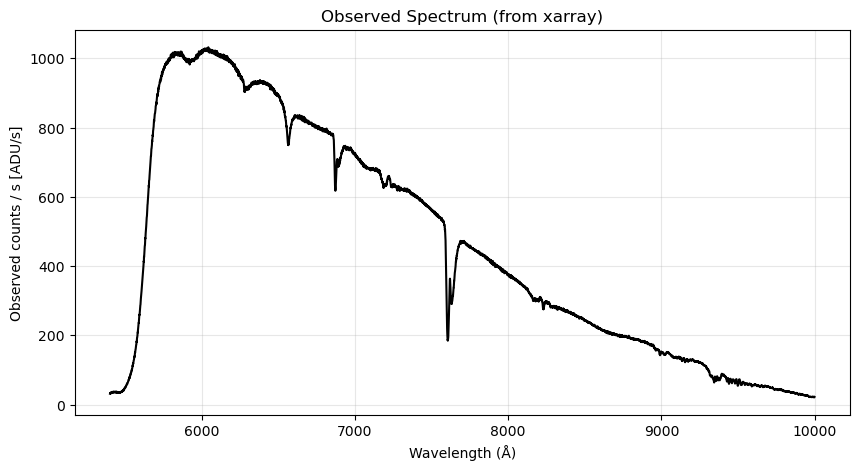

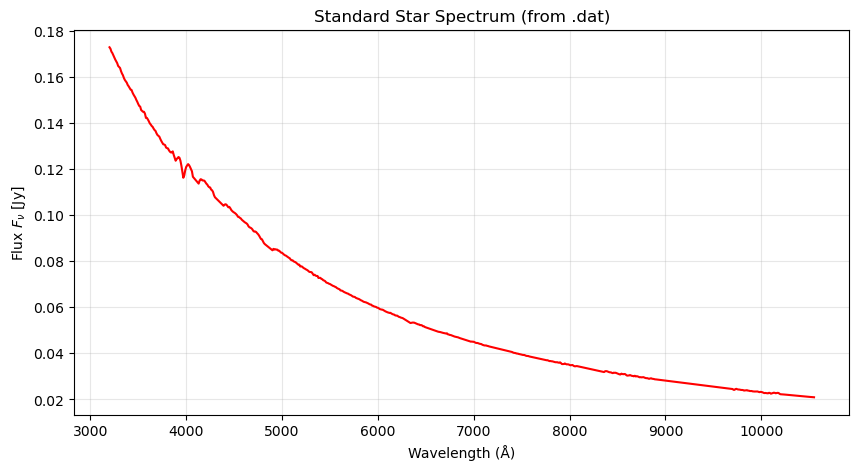

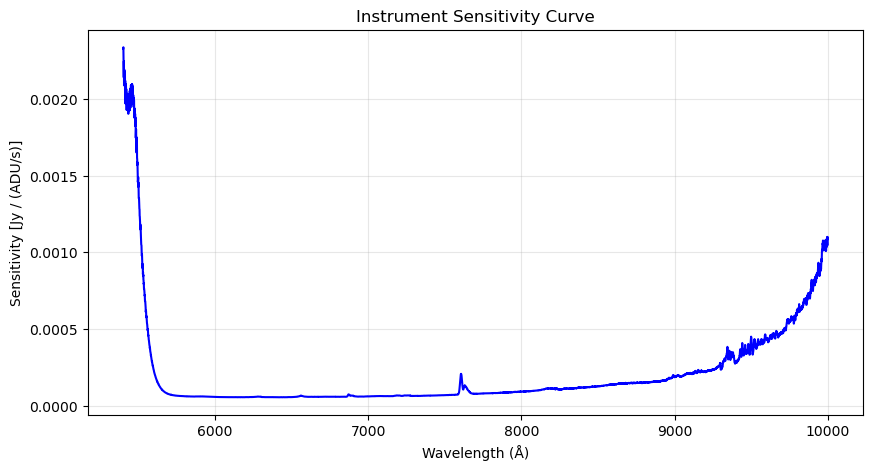

In [66]:
ds = xr.open_dataset("D:/Pavlicek, Emma/G191B2B/red/red_mods2r_spectra.h5", engine="h5netcdf")

# Pick one exposure (e.g., first one)
wavelengths = ds['wavelength'].values * u.AA
flux = ds['flux'].values[0, :] * u.adu      # counts
exptime = 90.0 * u.s
flux_rate = flux / exptime                   # ADU / s

observed_spectrum = Spectrum(
    spectral_axis=wavelengths,
    flux=flux_rate
)

# Load wavelength and ABmag (ignore error column)
std_wave_raw, std_flux_raw = np.loadtxt(
    "D:/Pavlicek, Emma/G191B2B/g191b2b_10a_fluxtable.dat",
    usecols=(0, 1), unpack=True
)


std_wave = std_wave_raw * u.AA   # wavelength in Angstrom


f_nu_Jy = 10**(-0.4 * (std_flux_raw - 8.9)) * u.Jy

standard_spectrum = Spectrum(
    spectral_axis=std_wave,
    flux=f_nu_Jy
)

resampler = FluxConservingResampler()
true_flux_interp = resampler(standard_spectrum, wavelengths)

sensitivity_curve = true_flux_interp.flux / observed_spectrum.flux


plt.figure(figsize=(10, 5))
plt.plot(wavelengths, flux_rate.value, color="black")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Observed counts / s [ADU/s]")
plt.title("Observed Spectrum (from xarray)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(std_wave, f_nu_Jy, color="red")
plt.xlabel("Wavelength (Å)")
plt.ylabel(r"Flux $F_\nu$ [Jy]")
plt.title("Standard Star Spectrum (from .dat)")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, sensitivity_curve.value, color="blue")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Sensitivity [Jy / (ADU/s)]")
plt.title("Instrument Sensitivity Curve")
plt.grid(alpha=0.3)
plt.show()

Calibrated flux has units: Jy


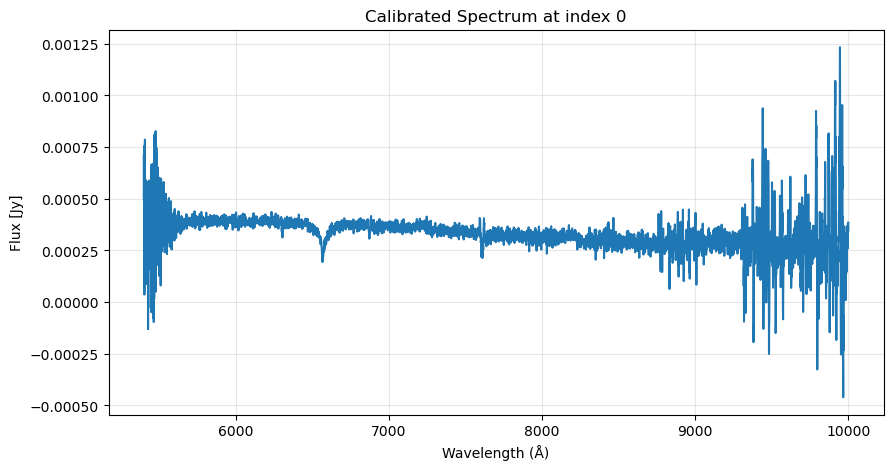

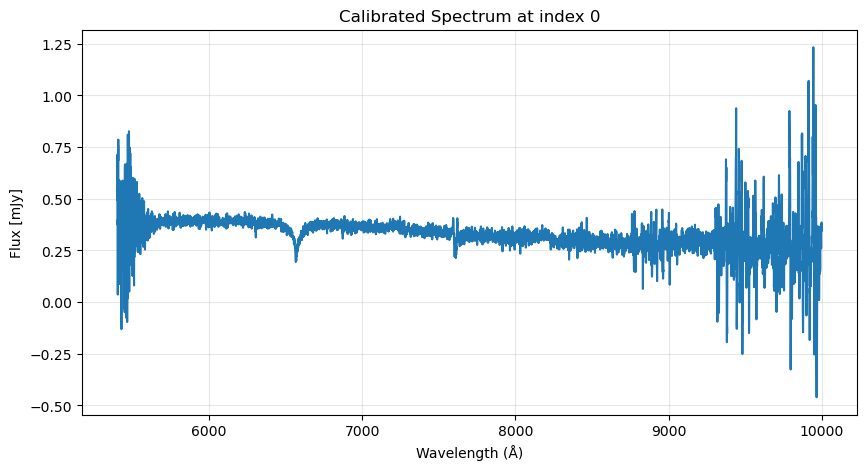

In [67]:
# Load your science target spectrum (e.g., WD1202)
ds_target = xr.open_dataset(
    "D:/Pavlicek, Emma/WD1202/red/WD1202_red_mods2r_spectra.h5", 
    engine="h5netcdf"
)
# Extract full flux and error arrays
# shape should be (time, wavelength)
flux_array = ds_target['flux'].values * u.adu
err_array = ds_target['flux_error'].values * u.adu

# Exposure time (assuming the same for all; if it varies, grab from dataset)
exptime = 90.0 * u.s

# Convert to flux rate
flux_rate = flux_array / exptime
err_rate = err_array / exptime

# Apply calibration curve (must be 1D, matching wavelength axis)
# sensitivity_curve shape = (wavelength,)
calibrated_flux = flux_rate * sensitivity_curve
calibrated_err = err_rate * sensitivity_curve

# If you want to keep this inside xarray for easy indexing:
calibrated_ds = xr.Dataset(
    {
        "calibrated_flux": (("time", "wavelength"), calibrated_flux.value),
        "calibrated_flux_err": (("time", "wavelength"), calibrated_err.value),
    },
    coords={
        "time": ds_target['time'].values if "time" in ds_target.coords else range(flux_array.shape[0]),
        "wavelength": ds_target['wavelength'].values,
    },
    attrs={"Jy": "flux in calibrated units"}
)

calibrated_ds.to_netcdf("D:/Pavlicek, Emma/WD1202/red/cal_mod2r.nc", engine="h5netcdf")

# The result is now a flux array in physical units (Janskys)
print(f"Calibrated flux has units: {calibrated_flux.unit}")

i = 0
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, calibrated_flux[i].value)
plt.xlabel("Wavelength (Å)")
plt.ylabel(r"Flux [Jy]")
plt.title(f"Calibrated Spectrum at index {i}")
plt.grid(alpha=0.3)
plt.show()

calibrated_flux_mJy = calibrated_flux * 1000
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, calibrated_flux_mJy[i].value)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux [mJy]")
plt.title(f"Calibrated Spectrum at index {i}")
plt.grid(alpha=0.3)
plt.show()